<a href="https://colab.research.google.com/github/jiananwu72/LuFeO3Detect/blob/main/LuFeO3/LFOSidpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install -q pyNSID sidpy SciFiReaders nanonispy gwyfile pyTEMlib wget ipympl importlib atomap
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.9/868.9 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.8/603.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.4 MB/s eta 0:00:00


In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../../sidpy')
import sidpy

%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


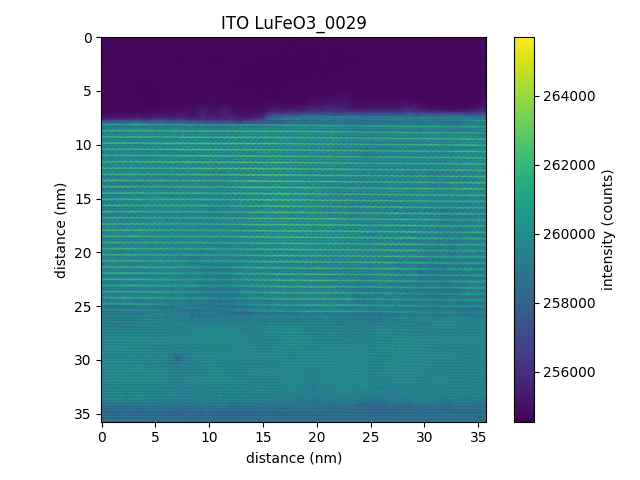

In [32]:
# When SciFiReaders can work, use this to load
import SciFiReaders as sr
dm3_file = '/content/drive/MyDrive/Data/LFO/ITO LuFeO3_0029.dm3'
dm3_reader = sr.DM3Reader(dm3_file)
dataset = dm3_reader.read()


# When SciFiReaders cannot work, load through hyperspy
# import hyperspy.api as hs
# filename = '/content/drive/MyDrive/Data/LFO/HAADF_01.dm3'
# s = hs.load(filename)
# dataset = sidpy.convert_hyperspy(s)

dataset = dataset['Channel_000']
dataset.plot();

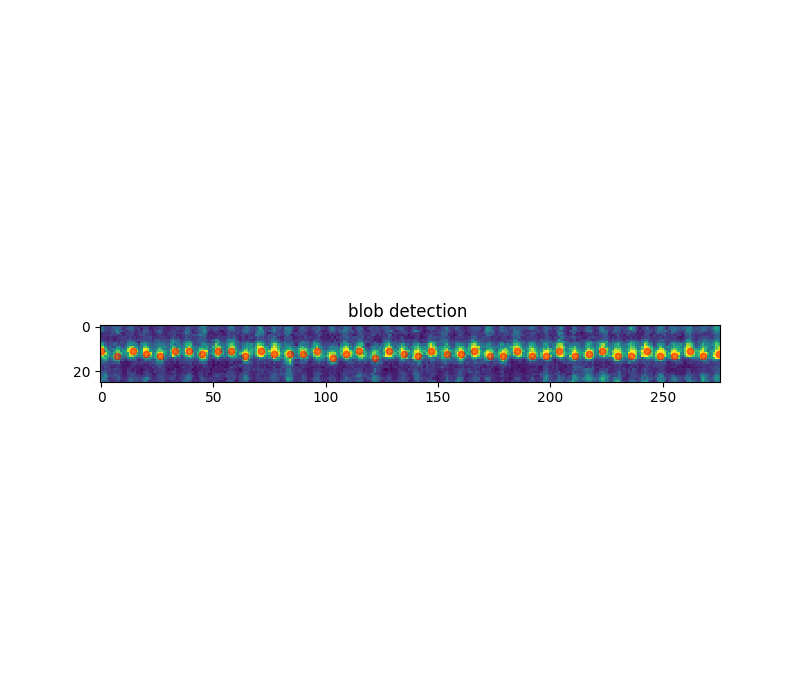

In [ ]:
import skimage
# ------- Input ------
threshold = 30 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .1 #in nm
min_atom_size = .02 #in nm
# ----------------------

dataset_cropped = dataset[:, 130:155]
image = dataset_cropped
#image = image_choice.dataset
# scale_x = pyTEMlib.file_tools.get_slope(image.dim_1)
scale_x =image.x.slope
blobs =  skimage.feature.blob_log(image, min_sigma = min_atom_size/scale_x, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

sidpy.Dataset of type IMAGE with:
 dask.array<sub, shape=(276, 25), dtype=float32, chunksize=(276, 25), chunktype=numpy.ndarray>
 data contains: Intensity (a.u.)
 and Dimensions: 
x:  Length (nm) of size (276,)
y:  Length (nm) of size (25,)
using radius  3 pixels


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyTEMlib/probe_tools.py:17: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


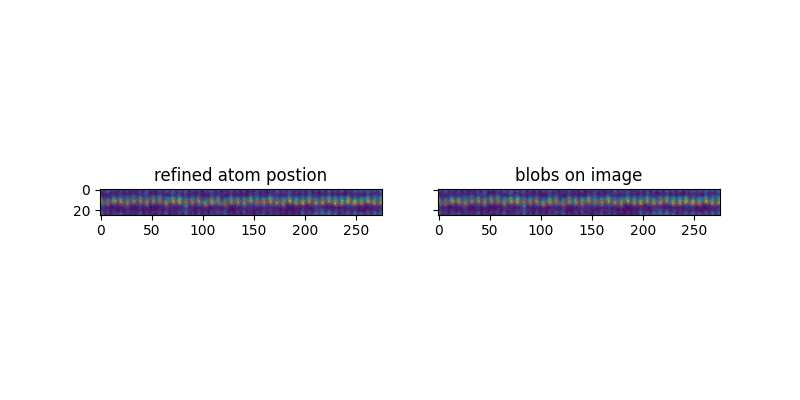

In [ ]:
out_tags  =  {}
out_tags['analysis']= 'Atom Positions'
# out_tags['notebook']= __notebook__
# out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'Atom finding'
out_tags['title'] = out_tags['name']
tags = {'atom_pixel':  out_tags}
# if isinstance(image.metadata['analysis'], str):
#     image.metadata['analysis']={image.metadata['analysis']:{}}

# image.metadata['analysis'].update(tags)

import pyTEMlib.atom_tools
atom_radius = 3
#atoms = atom_group['atoms'][()]
atoms = blobs
image = image-image.min()
print(image)

#atom_radius = 2
MaxInt = 0
MinInt = 0
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

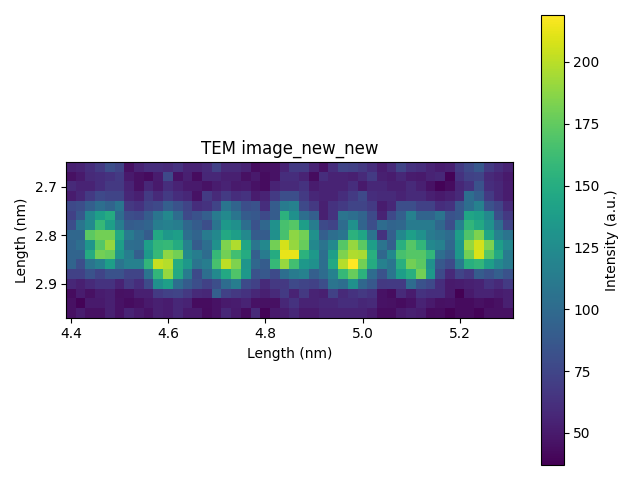

In [ ]:
refined_atoms.shape
windows = []
image = dataset_cropped
radius_x = 23
radius_y = 8
for i in range(refined_atoms.shape[0]):
    x = int(refined_atoms[i][0])
    y = int(refined_atoms[i][1])
    if x > radius_x and x < image.shape[0]-radius_x and y > radius_y and y < image.shape[1]-radius_y:
        window = image[x - radius_x:x + radius_x, y - radius_y:y + radius_y]
        windows.append(window)

windows[3].plot();

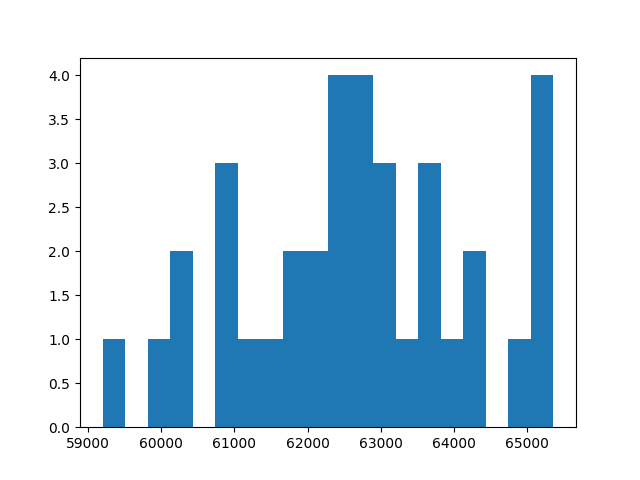

In [ ]:
sums = []
for i in range(len(windows)):
    sums.append(np.sum(np.array(windows[i])))

plt.figure()
plt.hist(sums, bins=20);